<a href="https://colab.research.google.com/github/min02yam/R/blob/main/20220815.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.패키지 및 데이터 로드


In [ ]:
install.packages(c("DataExplorer","imputeTS","pacman"))
pacman:: p_load("DataExplorer","imputeTS")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘xts’, ‘TTR’, ‘markdown’, ‘RCurl’, ‘png’, ‘jpeg’, ‘quadprog’, ‘quantmod’, ‘plyr’, ‘htmlwidgets’, ‘igraph’, ‘gridtext’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘reshape2’, ‘gridExtra’, ‘networkD3’, ‘ggtext’, ‘stinepack’, ‘forecast’, ‘Rcpp’




In [ ]:
suppressPackageStartupMessages({
require(data.table)
require(dplyr)
require(magrittr)
require(forecast)
})

In [ ]:
system("gdown --id 1RKNy3_xNxiTAs3ZDHsbBmFUqy_gpqb5r")

In [ ]:
dt = fread("2_visitors.csv")

# 2-1 & 2-2

In [ ]:
dt  %>% summary

       no           num         
 Min.   :  1   Min.   : 769002  
 1st Qu.: 77   1st Qu.:1197148  
 Median :153   Median :1330821  
 Mean   :153   Mean   :1342910  
 3rd Qu.:229   3rd Qu.:1476190  
 Max.   :305   Max.   :2297358  
               NA's   :3        

In [ ]:
ts=ts(dt[,2])

In [ ]:
ts_imp = na_kalman(ts)

- 칼만 필터 알고리즘 사용<br>
- 근거: 노이즈가 많은 측정치가 있는 경우 or 직접 보거나 측정할 수 없는 값을 추정하는 최적의 방법

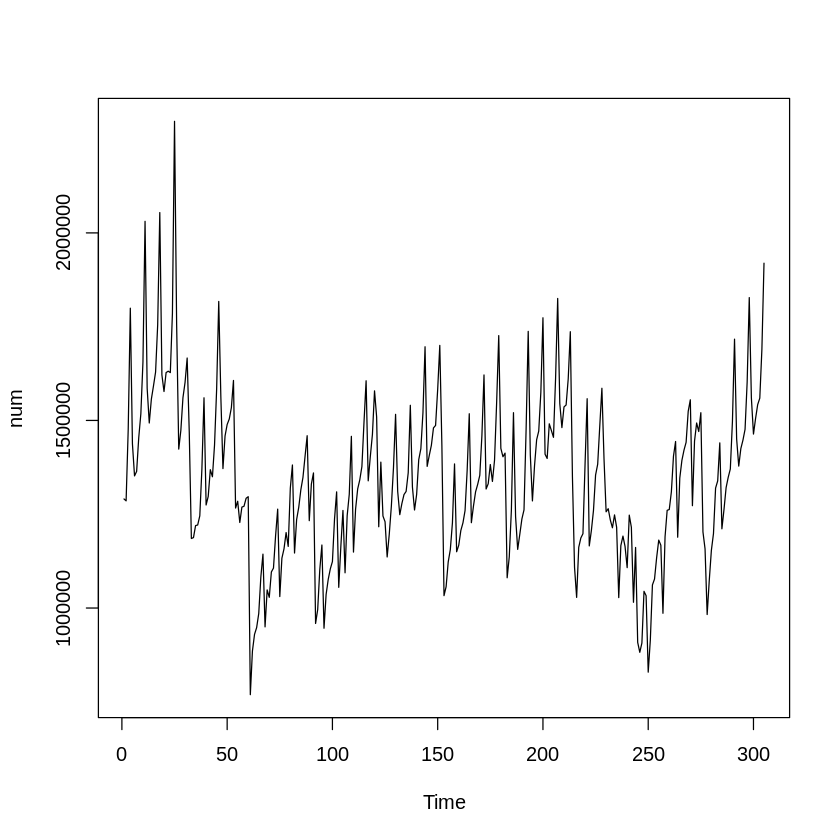

In [ ]:
plot(ts_imp)

- 관측치가 얼마 없긴 하지만, 이 그림으로만 봤을땐 어떠한 추세나 패턴이 있다고 판단하기 어렵고, 화이트 노이즈한 그림으로 보임
- 계절성이 없어 보이는데 어떻게 계절성을 포함하는 모델을 구축하는지 잘 모르겠음 


# 2-3 정확도 측면 -> TEST셋 생성

In [ ]:
ts_imp %>% nrow

[1] 305

In [ ]:
train = window(ts_imp, end = 295)
test = window(ts_imp , start=296)

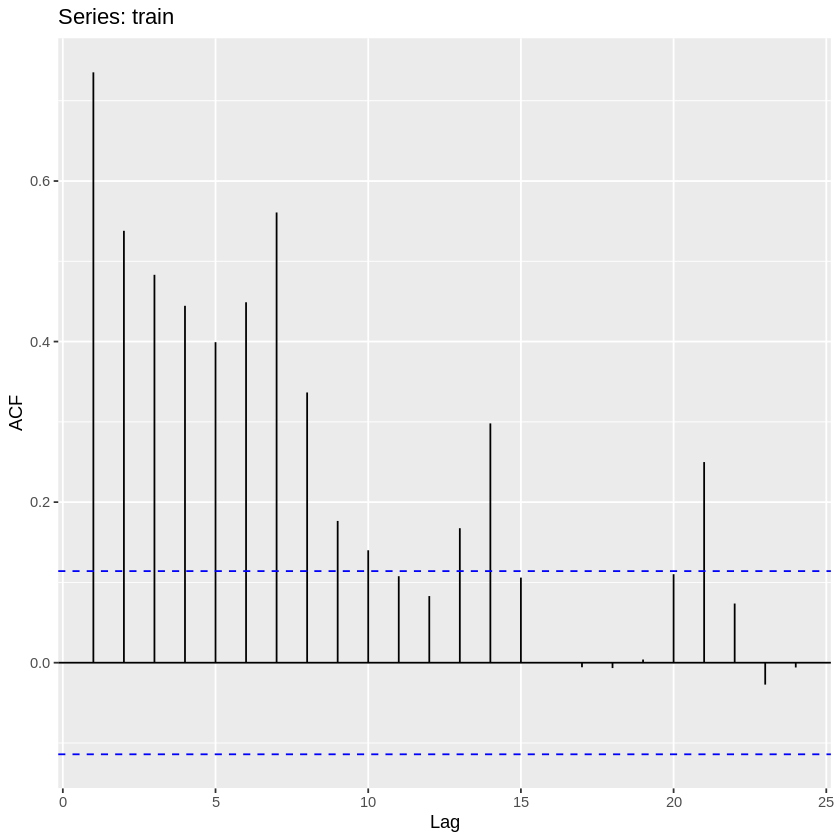

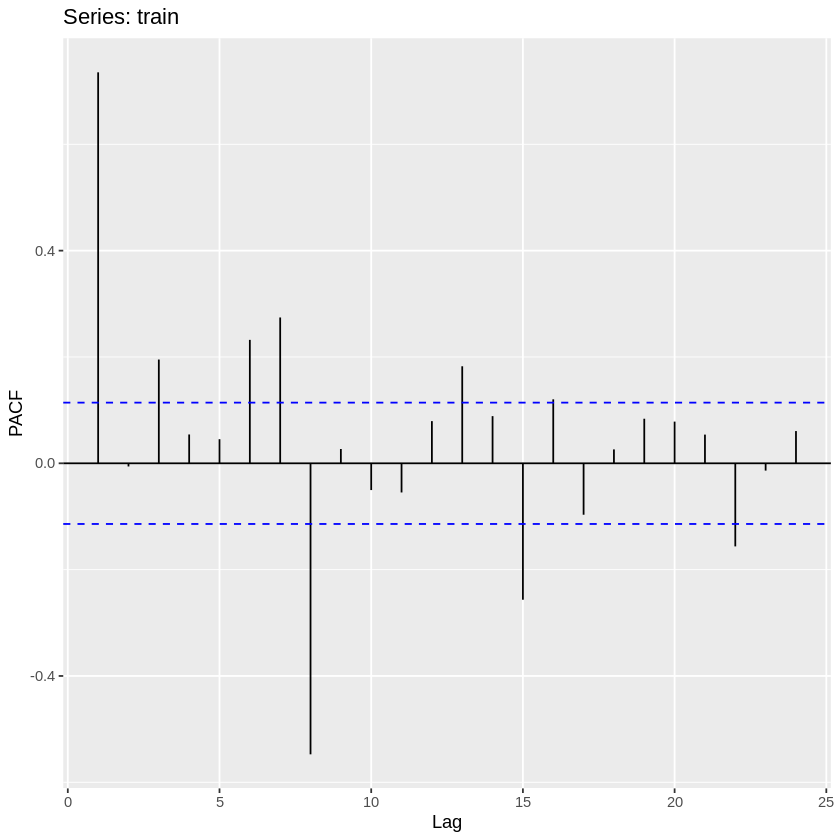

In [ ]:
par(mfrow=c(2,1))
autoplot(acf(train, plot=F))
autoplot(pacf(train, plot=F))

- 먼저, ACF와 PACF 그래프를 살펴봤을때 acf는 21시차 pacf는 15시차까지 보더라인을 넘어감 
- 절단 포인트가 길어서
- 모형 식별을 위한 적절한 판단이 어려움
- 오토아리마 함수 사용

In [ ]:
auto.arima(train)

Series: train 
ARIMA(5,1,2) 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ma1     ma2
      0.0255  -0.7390  -0.2662  -0.2474  -0.4393  -0.3008  0.5179
s.e.  0.1700   0.0738   0.0847   0.0542   0.0639   0.2100  0.0625

sigma^2 = 1.741e+10:  log likelihood = -3880.72
AIC=7777.45   AICc=7777.95   BIC=7806.92

- ARIMA(5,1,2) 모형으로 결정
- 계절성 반영 안하기로 결정

In [ ]:
fit=arima(train, order=c(5,1,2))
forcast = forecast(fit, h=nrow(ts_imp)-nrow(train))

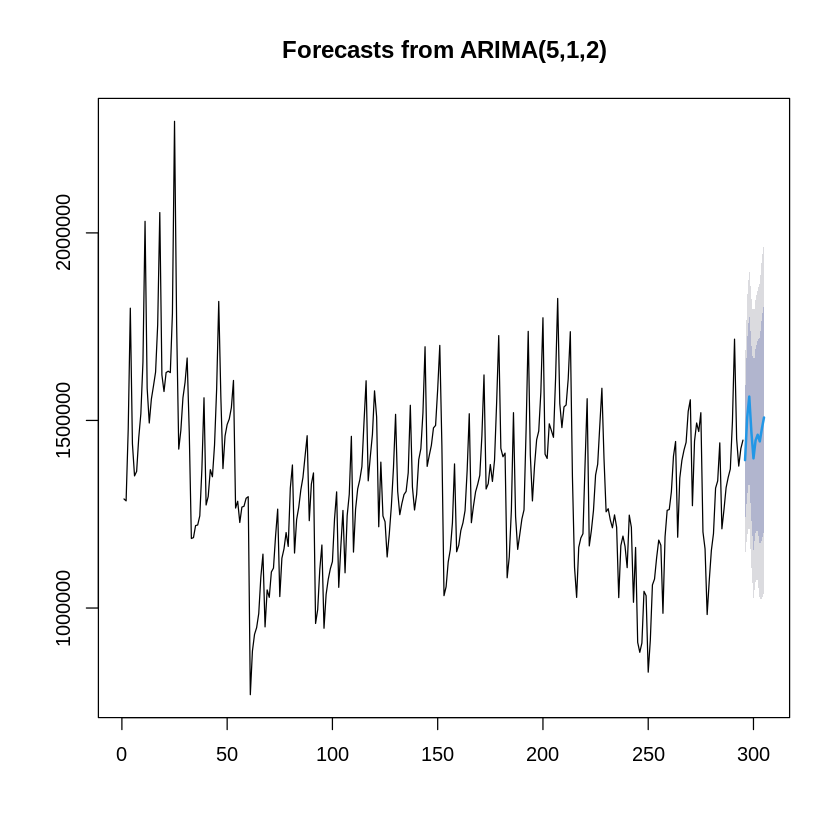

In [ ]:
plot(forcast)

In [ ]:
accuracy(forcast, test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,989.1685,130137.7,96307.46,-0.6743993,7.419342,0.844675,-0.03812819,NA
Test set,147309.6314,182962.2,147309.63,8.6587508,8.658751,1.291995,0.21792706,1.246815


## 계절성 반영

In [ ]:
#계절성 
sarima = arima(train, order=c(5,1,2), seasonal = list(order=c(5,1,2))) 
forcast2 = forecast(sarima, h=nrow(ts_imp)-nrow(train))
accuracy(forcast2, test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-1154.184,136984.2,101990.3,-0.4537137,7.92769,0.8945171,-0.0111045,NA
Test set,187365.075,230309.6,187897.3,11.0580827,11.09413,1.6479735,0.1077226,1.594303


반영 안한게 성능이 더 좋음

# 2-4 
- 예측 업무에 적용 할 수 없음. 정확도 성능이 비교적 좋지 않고 이를 개선하기 위해 더 많은 데이터가 필요함